# Test Door Key Offline Training with d3rlpy and Decision Transformer

We will use the Door Key 16x16 environment from Minigrid Gym to test the Decision Transformer algorithm from d3rlpy.

In [ ]:
# Test if we are running on CoLab or not
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  !apt-get install -y xvfb ffmpeg > /dev/null 2>&1
  %pip install pyvirtualdisplay pygame moviepy > /dev/null 2>&1
  %pip install d3rlpy
  %pip install matplotlib
else:
  print('Not running on CoLab')

In [ ]:
# Directory creation
import os
path = "./models"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

path = "./datasets"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

path = "./videos/video-doorkey-dt-d3rlpy"
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

In [ ]:
import gymnasium as gym
from gymnasium import spaces
from minigrid.envs import DoorKeyEnv
from gymnasium.core import ActType, ObsType
from typing import Any, SupportsFloat
import random, math
import numpy as np

from gymnasium.envs.registration import register

register(
    id="MiniGrid-DoorKey-16x16-v0",
    entry_point="minigrid.envs:DoorKeyEnv",
    kwargs={"size": 16},
)
    

We created a PartialObsWrapper to augment flattened partial observations with the agent's direction in a single vector. This is beneficial for training the Decision Transformer algorithm.

Additionally, we developed a PartialAndFullyObsWrapper to enhance flattened partial observations with the agent's direction in just one vector, and to append the full observation to the partial observation. This is advantageous for sampling data from the environment using the trained DQN agent, and for saving the data in a dataset.

In [ ]:
import minigrid
from minigrid.core.constants import COLOR_TO_IDX, OBJECT_TO_IDX
from gymnasium.core import ObservationWrapper

class PartialObsWrapper(ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        new_image_space = spaces.Box(
            low=0,
            high=255,
            shape=(((self.env.agent_view_size * self.env.agent_view_size *  3) + 1),),  
            dtype="uint8",
        )

        self.observation_space = spaces.Dict(
            {**self.observation_space.spaces, "image": new_image_space}
        )

    def observation(self, obs):
        image = np.concatenate((obs["image"].flatten(), np.array([obs["direction"]])))

        return {"image": image}

class PartialAndFullyObsWrapper(ObservationWrapper):

    def __init__(self, env):
        super().__init__(env)

        new_image_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.env.width, self.env.height, 3),  # number of cells
            dtype="uint8",
        )

        self.observation_space = spaces.Dict(
            {**self.observation_space.spaces, "image": new_image_space}
        )

    def observation(self, obs):
        env = self.unwrapped
        full_grid = env.grid.encode()
        full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array(
            [OBJECT_TO_IDX["agent"], COLOR_TO_IDX["red"], env.agent_dir]
        )

        partial_image = np.concatenate((obs["image"].flatten(), np.array([obs["direction"]])))

        return {"partial_image": partial_image, "image": full_grid}

def create_env(env_key, max_episode_steps=100, isPartialObs=False, isFullyObs=True, is_video=False):
    
    render_mode = None

    if is_video == True:
        render_mode = 'rgb_array'

    env = gym.make(env_key, max_episode_steps=max_episode_steps, render_mode=render_mode, see_through_walls=True)

    if isPartialObs and isFullyObs:
        env =  PartialAndFullyObsWrapper(env)
    elif isPartialObs:
        env = PartialObsWrapper(env)
        env = minigrid.wrappers.ImgObsWrapper(env)
    elif isFullyObs:
        env = minigrid.wrappers.FullyObsWrapper(env)
        env = minigrid.wrappers.ImgObsWrapper(env)

    return env


We retrieve the DQN agent trained in the notebook 'train-door-key-16x16-dqn.ipynb'. This agent is employed to sample data from the environment and to store this data in a dataset. This approach allows us to use the trained agent to generate expert data for the Decision Transformer algorithm. Additionally, this agent is utilized to assess the performance of the Decision Transformer algorithm. The agent is competent enough to solve the environment, though it is not flawless.

In [ ]:
import d3rlpy
import gymnasium as gym
import torch
import torch.nn as nn
from d3rlpy.models.encoders import EncoderFactory

class CustomConvEncoder(nn.Module):
    def __init__(self, observation_shape):
        super().__init__()
        print(observation_shape)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=1, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv2Dropout = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.conv3Dropout = nn.Dropout(0.5)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)
        self.conv4Dropout = nn.Dropout(0.5)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)
        self.conv5Dropout = nn.Dropout(0.5)


    def forward(self, x):
        h = x.permute(0, 3, 1, 2)
        h = torch.relu(self.conv1(h))
        h = torch.relu(self.conv2Dropout(self.conv2(h)))
        h = torch.relu(self.conv3Dropout(self.conv3(h)))
        h = torch.relu(self.conv4Dropout(self.conv4(h)))
        h = torch.relu(self.conv5Dropout(self.conv5(h)))

        h = torch.flatten(h, start_dim=1)
        #print(h.shape)

        return h
    
class CustomConvEncoderFactory(EncoderFactory):

    def create(self, observation_shape):
        return CustomConvEncoder(observation_shape)

    @staticmethod
    def get_type() -> str:
        return "custom"
    


In [ ]:
config = {
    "seed": 1,
    "dataset_size": 10000,
    "epsilon": 0.3,
    "max_episode_steps": 200,
    "experiment_name": "door-key-16x16",
    "device": "cuda:0"
}

env_key = "MiniGrid-DoorKey-16x16-v0"

env = create_env(env_key, max_episode_steps=config["max_episode_steps"])

dqn = d3rlpy.algos.DQNConfig(
    encoder_factory=CustomConvEncoderFactory(),
    batch_size=100,
    gamma=0.9,
    target_update_interval=1000,
    learning_rate=2.5e-4
).create(device=config["device"])

dqn.build_with_env(env)

dqn.load_model('./models/model_door-key-dqn-16x16.pt')


We develop a CustomReplayBuffer to exclude episodes that have zero or negative rewards. Our goal is to retain only those episodes in which the agent is making progress towards the goal.

In [ ]:
import numpy as np
from tqdm import tqdm


class CustomReplayBuffer(d3rlpy.dataset.ReplayBuffer):
    ' Custom Replay Buffer to clip episodes with negative rewards'
    
    def clip_episode(self, terminated: bool) -> None:
        r"""Clips the current episode.

        Args:
            terminated: Flag to represent environment termination.
        """

        episode_to_remove = None
        # Check if the episode's reward is 0 or negative
        if not terminated and self._writer._active_episode.rewards.mean() <= 0:
            episode_to_remove = self._writer._active_episode
            
        self._writer.clip_episode(terminated)

        if episode_to_remove is not None:
            # Remove all transitions associated with the episode to remove
            self._buffer._transitions = [(ep, idx) for ep, idx in self._buffer._transitions if ep is not episode_to_remove]
            self._buffer.episodes.remove(episode_to_remove)  



We populate the buffer dataset with data sampled from the environment using the trained DQN agent. We utilize the PartialAndFullyObsWrapper to employ full observation for the DQN agent while saving the partial observation in the dataset. We continue sampling until the dataset is filled exclusively with positive rewards. To create a mix of non-expert and expert data, we initially introduce more entropy into the actions sampled from the DQN agent and gradually reduce the entropy to produce expert data. This is a slow process, but it is the only method we have found to generate expert data automatically.

In [ ]:
env_data = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)
env_sampler = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=True)

buffer = d3rlpy.dataset.InfiniteBuffer()
dataset = CustomReplayBuffer(buffer, env=env_data, cache_size=config["max_episode_steps"])

seed = 1

done = False

observation, _ = env_sampler.reset()

num_steps = 0
count_done = 0
count_truncated = 0

epsilon = 0.5
epsilon_min = 0.1
epsilon_decrement = (epsilon - epsilon_min) / 10  


pbar = tqdm(total=config["dataset_size"])

while dataset.size() < config["dataset_size"]:

    pbar.update(dataset.size() - pbar.n) 

    if dataset.size() >= (config["dataset_size"] * (1 - (epsilon - epsilon_min) / (epsilon - epsilon_decrement))):
        epsilon = max(epsilon - epsilon_decrement, epsilon_min)

    explorer = d3rlpy.algos.ConstantEpsilonGreedy(epsilon=epsilon)

    while True:
        x = np.expand_dims(observation['image'], axis=0)

        action = explorer.sample(dqn, x, 0)[0]

        next_observation, reward, done, truncated, _ = env_sampler.step(action)

        clip_episode = done or truncated

        # store observation
        dataset.append(observation['partial_image'], action, float(reward))

        # reset if terminated
        if clip_episode:
            dataset.clip_episode(done)
            observation, _ = env_sampler.reset()
            if done:
                count_done += 1
            if truncated:
                count_truncated += 1
            break
        else:
            observation = next_observation

pbar.close()
env.close()

print("Dataset size: ", dataset.size())
print("Truncated: ", count_truncated)

dataset.dump('./datasets/dataset_door-key-dqn-16x16-mixed.d3')


We train the Discrete Decision Transformer agent using the data sampled from the environment. We employ the PartialObsWrapper to augment the partial observation with the agent's direction.

In [132]:
env_dt = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)
env_dt_eval = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)

buffer = d3rlpy.dataset.InfiniteBuffer()
dataset = CustomReplayBuffer(buffer, env=env_dt, cache_size=config["max_episode_steps"])

dataset.load('./datasets/dataset_door-key-dqn-16x16-mixed.d3', buffer=buffer)


target_return = 1
experiment_name = config["experiment_name"]
experiment_seed = config["seed"]

d3rlpy.seed(experiment_seed)
d3rlpy.envs.seed_env(env, experiment_seed)

dt = d3rlpy.algos.DiscreteDecisionTransformerConfig(
    batch_size=64,
    encoder_factory=d3rlpy.models.VectorEncoderFactory(
    ),
    optim_factory=d3rlpy.models.GPTAdamWFactory(),
    position_encoding_type=d3rlpy.PositionEncodingType.GLOBAL,
    context_size=60,
    num_heads=8,
    num_layers=3,
    max_timestep=200,
).create(device=config["device"])


dt.fit(                                                                                                                                                                                                                                                                                                                                                                                                                                                             
    dataset,
    n_steps=10000,
    n_steps_per_epoch=2000,
    eval_env=env_dt_eval,
    eval_target_return=1,
    eval_action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(
        temperature=1.0,
    ),
    experiment_name=f"DT_{experiment_name}_{experiment_seed}"
)


2024-01-23 15:53.21 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[()]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[[1]])
2024-01-23 15:53.21 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-23 15:53.21 [info     ] Action size has been automatically determined. action_size=7
2024-01-23 15:53.29 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('uint8')], shape=[(148,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2024-01-23 15:53.29 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-01-23 15:53.29 [info     ] Action size has been automatically determined. action_size=7
2024-01-23 15

Epoch 1/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-23 15:56.12 [info     ] DT_door-key-16x16_1_20240123155329: epoch=1 step=2000 epoch=1 metrics={'time_sample_batch': 0.008360352039337158, 'time_algorithm_update': 0.06885318326950073, 'loss': 0.6986446649283171, 'learning_rate': 0.000586854190981062, 'time_step': 0.07737573742866516, 'environment': 0.38987499999999997} step=2000
2024-01-23 15:56.12 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123155329/model_2000.d3


Epoch 2/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-23 15:58.34 [info     ] DT_door-key-16x16_1_20240123155329: epoch=2 step=4000 epoch=2 metrics={'time_sample_batch': 0.007384556651115417, 'time_algorithm_update': 0.060282236576080325, 'loss': 0.6478464986234903, 'learning_rate': 0.0005145545306444254, 'time_step': 0.06779557120800019, 'environment': 0.6721914062500001} step=4000
2024-01-23 15:58.34 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123155329/model_4000.d3


Epoch 3/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-23 16:01.02 [info     ] DT_door-key-16x16_1_20240123155329: epoch=3 step=6000 epoch=3 metrics={'time_sample_batch': 0.007374895691871643, 'time_algorithm_update': 0.06381214225292206, 'loss': 0.6184482524693012, 'learning_rate': 0.0003870679723529984, 'time_step': 0.07131910729408264, 'environment': 0.9666015625} step=6000
2024-01-23 16:01.02 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123155329/model_6000.d3


Epoch 4/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-23 16:05.03 [info     ] DT_door-key-16x16_1_20240123155329: epoch=4 step=8000 epoch=4 metrics={'time_sample_batch': 0.007675033569335937, 'time_algorithm_update': 0.10666953492164612, 'loss': 0.5762494428306818, 'learning_rate': 0.00023726335260661582, 'time_step': 0.11447856402397155, 'environment': 0.9665664062499999} step=8000
2024-01-23 16:05.03 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123155329/model_8000.d3


Epoch 5/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-01-23 16:09.43 [info     ] DT_door-key-16x16_1_20240123155329: epoch=5 step=10000 epoch=5 metrics={'time_sample_batch': 0.007852122902870178, 'time_algorithm_update': 0.1266483691930771, 'loss': 0.4946281714141369, 'learning_rate': 0.00010412782734397075, 'time_step': 0.13463107264041901, 'environment': 0.9719101562500001} step=10000
2024-01-23 16:09.43 [info     ] Model parameters are saved to d3rlpy_logs/DT_door-key-16x16_1_20240123155329/model_10000.d3


We make a video of the trained agent.

In [136]:
import gymnasium as gym

import numpy as np
from gym.wrappers import RecordVideo


# start virtual display
d3rlpy.notebook_utils.start_virtual_display()

env_video = create_env(env_key, max_episode_steps=200, is_video=True, isPartialObs=True, isFullyObs=False)

env_video = RecordVideo(env_video, './videos/video-doorkey-dt-d3rlpy')

# wrap as stateful actor for interaction
actor = dt.as_stateful_wrapper(
    target_return=1,
    action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(temperature=1.0,)
)

done = False

actor.reset()
observation, reward = env_video.reset()

while True:

    action = actor.predict(observation, 1) 

    observation, reward, done, truncated, _ = env_video.step(action)

    if done:
        print("reward:", reward)
        print("DONE!!!")
        break
    elif truncated:
        print("Truncated")
        break

env.close()

d3rlpy.notebook_utils.render_video("./videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4")


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_view_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_view_size` for environment variables or `env.get_wrapper_attr('agent_view_size')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gym/wrappers/record_video.py:75: UserWarning: WARN: Overwriting existing videos at /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_vector_env to get variables from other wrappers is dep

Moviepy - Building video /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4.
Moviepy - Writing video /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/drinf/Desktop/PROJECTS/machine_learning/fib_postgraduate/GameMindsDT/experiments/notebooks/videos/video-doorkey-dt-d3rlpy/rl-video-episode-0.mp4
reward: 0.98171875
DONE!!!


In [137]:
dt.save_model('./models/model_door-key-dt-16x16-128-d3rlpy.pt')

In [ ]:
dt = d3rlpy.load_learnable()

# Conclusion
We evaluate the DT-trained agent by comparing it with the DQN agent. We can see that the DT agent is superior to the DQN agent. The DT agent solves the environment more frequently than the DQN agent. The most important thing to observe is that the DT agent can solve the environment with only partial observation, and without being rewarded for picking up the key or opening the door. The DT agent manages to solve the environment solely with the reward for reaching the goal. Furthermore, the DT agent can solve the environment using only the data generated by the DQN agent. The DT agent is capable of learning from the data produced by the DQN agent. The result is an agent that is better than its 'teacher'. 

## Unestable Training
Despite this, we have noticed that the training is very unstable, and it can yield very different results in each epoch. We need to continue investigating this issue a little bit more.

In [139]:
# We are going to compare the performance of DQN and DT

trials = 1000

def evaluate_policy(env, actor, explorer=None, n_trials=10):

    success = 0
    for _ in tqdm(range(n_trials)):
        
        if (explorer is  None):
            actor.reset()
        obs,_ = env.reset()

        done, truncated = False, False
        while not (done or truncated):
            if explorer is not None:
                x = np.expand_dims(obs, axis=0)
                action = explorer.sample(actor, x, 0)[0]
            else:
                action = actor.predict(obs, 1)
            obs, reward, done, truncated, _ = env.step(action)
            if done and reward > 0:
                success += 1
    return success / n_trials

env_dqn = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=False, isFullyObs=True)
env_dt = create_env(env_key, max_episode_steps=config["max_episode_steps"], isPartialObs=True, isFullyObs=False)

dqn.build_with_env(env_dqn)
dqn.load_model('./models/model_door-key-dqn-16x16.pt')

#dt.build_with_env(env_dt)
#dt.load_model('./models/model_door-key-dt-16x16-128-d3rlpy.pt')

explorer_dqn = d3rlpy.algos.ConstantEpsilonGreedy(epsilon=config["epsilon"])

actor_dt = dt.as_stateful_wrapper(
    target_return=1,
    action_sampler=d3rlpy.algos.SoftmaxTransformerActionSampler(temperature=1.0,)
)

dqn_score = evaluate_policy(env_dqn, dqn, explorer=explorer_dqn, n_trials=trials)
dt_score = evaluate_policy(env_dt, actor_dt, n_trials=trials)

print("DQN score:", dqn_score)
print("DT score:", dt_score)



2024-01-23 16:17.37 [warning  ] Parameters will be reinitialized.


/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.width to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.width` for environment variables or `env.get_wrapper_attr('width')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.height to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.height` for environment variables or `env.get_wrapper_attr('height')` that will search the reminding wrappers.
  logger.warn(
/home/drinf/anaconda3/envs/decision-transformers/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_view_size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this var

(16, 16, 3)
(16, 16, 3)


100%|██████████| 1000/1000 [09:55<00:00,  1.68it/s]

DQN score: 0.622
DT score: 0.874


We create a bar plot to compare the rewards of the DQN agent and the DT agent. It is apparent that the DT agent solves the environment more often than the DQN agent.

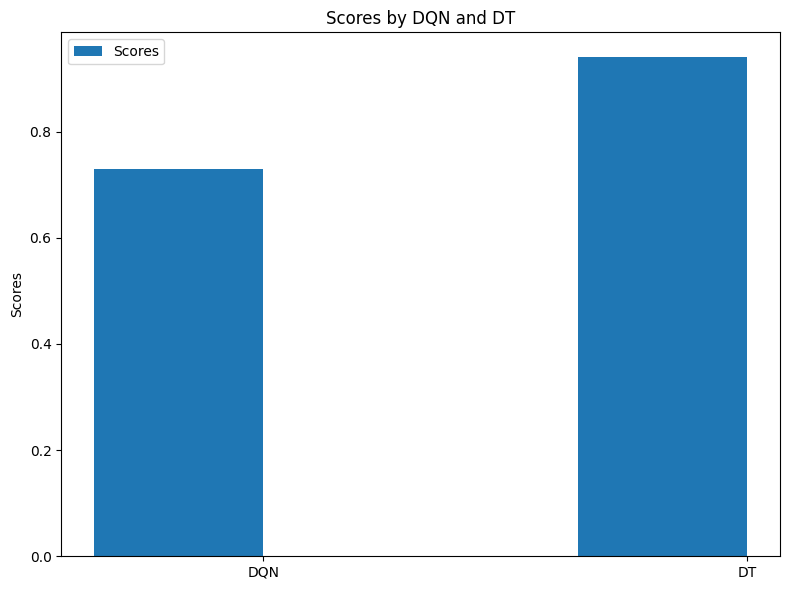

In [138]:
# We will make a bar chart to compare the performance of DQN and DT

import matplotlib.pyplot as plt

labels = ['DQN', 'DT']
scores = [dqn_score, dt_score]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, scores, width, label='Scores')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by DQN and DT')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

